In [1]:
# Installazione di transformers 4.30.0 e versioni compatibili di peft e accelerate
!pip install transformers==4.30.0
!pip install peft==0.3.0  # Versione compatibile con transformers 4.30.0
!pip install accelerate==0.18.0  # Versione compatibile con transformers 4.30.0
!pip install datasets scipy ipywidgets

# Disinstallazione delle versioni precedenti di torch e librerie correlate
!pip uninstall torch torchtext torchvision torchaudio -y

# Installazione delle versioni compatibili di torch e librerie correlate
!pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 torchtext==0.16.0

# Installazione di Ludwig e altre librerie specifiche
!pip install bitsandbytes>=0.41.3
!pip install git+https://github.com/ludwig-ai/ludwig.git@master --quiet
!pip install bert-score
!pip install ludwig[llm]
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 71.7 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━

In [2]:
import os
import gc

from google.colab import data_table

import numpy as np
import pandas as pd

import torch
from torch import Tensor

import datasets
from datasets import Dataset, DatasetDict

import yaml
from ludwig.api import LudwigModel, TrainingResults

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
from google.colab import files
uploaded = files.upload()

Saving Output.csv to Output.csv


In [4]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [5]:
from google.colab import output
output.disable_custom_widget_manager()

In [6]:
import pandas as pd

file_name = "Output.csv"
try:
    # Prova a leggere il file con il delimitatore corretto
    df = pd.read_csv(file_name, delimiter=',', on_bad_lines='warn')
except pd.errors.ParserError as e:
    print(f"Error parsing CSV file: {e}")

# Rimuove il carattere `;` dal nome della colonna
df.columns = [col.strip(';') for col in df.columns]

# Visualizza le prime righe del dataset
print(df.head())

                                             DOMANDE  \
0  Ho avuto un breve affanno dopo una passeggiata...   
1  Dovrei essere preoccupato se ho sperimentato u...   
2  Dovrei essere preoccupato se ho avuto un legge...   
3  È motivo di preoccupazione se ho avuto un brev...   
4  Dovrei essere preoccupato se ho avuto un po' d...   

                                            RISPOSTE  
0  Capisco che possa essere preoccupante, ma un b...  
1  È comprensibile essere preoccupati per un epis...  
2  L'affanno dopo una camminata può essere normal...  
3  È comprensibile essere preoccupati per un brev...  
4  L'affanno dopo una passeggiata può essere norm...  


Skipping line 35: expected 2 fields, saw 3



In [7]:
# Pulizia del dataset
df_cleaned = df.dropna()

In [8]:
from transformers import AutoTokenizer
# Funzione per calcolare la lunghezza media delle domande e delle risposte in token
def calculate_average_length(df, question_col, answer_col, model_name='bert-base-uncased'):
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Tokenizzazione e calcolo delle lunghezze
    df['question_length'] = df[question_col].apply(lambda x: len(tokenizer.tokenize(x)))
    df['answer_length'] = df[answer_col].apply(lambda x: len(tokenizer.tokenize(x)))

    # Calcolo della lunghezza media
    avg_question_length = df['question_length'].mean()
    avg_answer_length = df['answer_length'].mean()

    return avg_question_length, avg_answer_length

In [9]:
# Esempio di utilizzo con il tuo DataFrame df_cleaned
avg_question_length, avg_answer_length = calculate_average_length(df_cleaned, 'DOMANDE', 'RISPOSTE')
print(f'Lunghezza media delle domande in token: {avg_question_length}')
print(f'Lunghezza media delle risposte in token: {avg_answer_length}')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Lunghezza media delle domande in token: 24.612508497620667
Lunghezza media delle risposte in token: 79.88715159755269


In [10]:
from sklearn.utils import resample
import nlpaug.augmenter.word as naw

# Bilanciamento del dataset
min_class_size = df_cleaned['DOMANDE'].value_counts().min()
df_balanced = df_cleaned.groupby('DOMANDE').apply(lambda x: resample(x, replace=False, n_samples=min_class_size)).reset_index(drop=True)

# Augmentazione dei dati
aug = naw.SynonymAug(aug_src='wordnet')

df_balanced['DOMANDE_aug'] = df_balanced['DOMANDE'].apply(lambda x: aug.augment(x))
df_balanced['RISPOSTE_aug'] = df_balanced['RISPOSTE'].apply(lambda x: aug.augment(x))

df_augmented = pd.concat([df_balanced[['DOMANDE', 'RISPOSTE']],
                          df_balanced[['DOMANDE_aug', 'RISPOSTE_aug']].rename(columns={'DOMANDE_aug': 'DOMANDE', 'RISPOSTE_aug': 'RISPOSTE'})])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [11]:
df_augmented['DOMANDE'] = df_augmented['DOMANDE'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))
df_augmented['RISPOSTE'] = df_augmented['RISPOSTE'].apply(lambda x: ' '.join(x) if isinstance(x, list) else str(x))

In [12]:
#suddivisione del set di dati in un set di addestramento 60%, in uno di test 20% e in uno di validazione 20%
from sklearn.model_selection import train_test_split

df_train, df_temp = train_test_split(df_augmented, test_size=0.4, random_state=200)
df_test, df_validation = train_test_split(df_temp, test_size=0.5, random_state=200)

In [13]:
# Verifica delle dimensioni
print(f'Train set size: {df_train.shape}')
print(f'Test set size: {df_test.shape}')
print(f'Validation set size: {df_validation.shape}')

Train set size: (1720, 2)
Test set size: (574, 2)
Validation set size: (574, 2)


In [14]:
# Aggiungere una colonna per indicare lo split (per indicare quale riga appartiene a quale suddivisione.)
df_train["split"] = np.zeros(df_train.shape[0])
df_test["split"] = np.ones(df_test.shape[0])
df_validation["split"] = np.full(df_validation.shape[0], 2)

df_dataset = pd.concat([df_train, df_test, df_validation])
df_dataset["split"] = df_dataset["split"].astype(int)

# Verifica delle dimensioni complessive
print(df_dataset.shape)

(2868, 3)


In [15]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

# Percorso alla cartella del modello salvato
model_path: str = "GroNLP/gpt2-small-italian"

# Carica il tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    model_path,
    model_max_length=512,
    trust_remote_code=True,     #esecuzione di codice da remoto
    padding_side="left",        #aggiunta del padding a sinistra (allineato a dx)
    add_eos_token=True)         #determina se aggiungere un token di fine sequenza

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_in_8bit=False,
    llm_int8_threshold=6.0,               # imposta una soglia per la quantizzazione INT8. Una soglia di 6.0 significa che solo i valori dei pesi con una magnitudine maggiore di 6.0 saranno quantizzati in INT8, mentre i pesi con magnitudine minore resteranno in precisione floating point.
    llm_int8_has_fp16_weight=False,       # il modello quantizzato non contiene pesi in formato FP16 quando vengono quantizzati in INT8. (minore precisione rispetto FP32)
    bnb_4bit_compute_dtype="float16",     # imposta il tipo di dato utilizzato per i calcoli nei modelli quantizzati a 4 bit (bnb_4bit).
    bnb_4bit_use_double_quant=True,       # Indica che viene utilizzata una doppia quantizzazione per i modelli a 4 bit (i pesi sono quantizzati in due passaggi, migliorando la precisione della quantizzazione).
    bnb_4bit_quant_type="nf4",            # tipo di quantizzazione utilizzato per i modelli a 4 bit (formato normalizzato a 4 bit).
)


model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype=torch.float16,
    offload_folder="offload",     # Offload di parti del modello sulla CPU
    trust_remote_code=True,       # Permette di eseguire codice che non è stato incluso nel repository locale.
    low_cpu_mem_usage=True,       # il modello viene caricato in modo da minimizzare l'utilizzo della memoria della CPU. Parti del modello vengono caricate sulla GPU.
   quantization_config=bnb_config
)

tokenizer_config.json:   0%|          | 0.00/135 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/959 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/487k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/287k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/448M [00:00<?, ?B/s]

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.


In [16]:
from google.colab import drive
drive.mount('/content/drive')

# Definisci il percorso di output per Google Colab
output_dir = "/content/drive/My Drive/BERT_SCORE_RESULTS_LUDWIG"
responses_filename_pre = "pre_fine_tuning_responses.xlsx"
scores_filename_pre = "pre_fine_tuning_scores.xlsx"
responses_filename_post = "post_fine_tuning_responses.xlsx"
scores_filename_post = "post_fine_tuning_scores.xlsx"

# Assicurati che la directory di output esista
os.makedirs(output_dir, exist_ok=True)

Mounted at /content/drive


In [17]:
# Estrazione di 150 domande casuali dal DataFrame originale
#eval_df = df_test[['DOMANDE', 'RISPOSTE']]
#eval_df = df_test.sample(n=150, random_state=42)

# Calcola la metà del numero totale di righe
#num_rows = len(df_test)
#half_num_rows = num_rows // 2  # Usa // per ottenere un numero intero
eval_df = df_test[['DOMANDE', 'RISPOSTE']]
# Estrai un campione casuale di metà delle righe dal DataFrame
eval_df = df_test.sample(n=100, random_state=42)

# Estrai le risposte di riferimento
reference_responses = eval_df['RISPOSTE'].tolist()

In [18]:
print(len(eval_df))

100


In [19]:
#Funzione per assicurarsi che le frasi termino con u punto
def ensure_ending_with_period(response):
    response = response.strip()
    if not response.endswith('.'):
       response += '.'
    return response

In [20]:
prompt_template: str = """
    Sei un esperto cardiologo. Rispondi alla seguente domanda in modo empatico e con frasi complete e concise, terminando ogni frase con un punto.
    ### Esempio 1:
    Domanda: Quali sono i sintomi dell'ipertensione?
    Risposta: I sintomi dell'ipertensione includono mal di testa, vertigini e difficoltà respiratorie.
    ### Esempio 2:
    Domanda: Come posso controllare la mia pressione arteriosa?
    Risposta: Puoi controllare la tua pressione arteriosa con una dieta sana, esercizio fisico regolare e farmaci prescritti.
    ### Domanda: {DOMANDE}
    ### Risposta (Assicurati che la tua risposta termini con un punto e abbia senso compiuto):
"""

In [21]:
from transformers import pipeline

# Funzione per generare risposte e calcolare BERTScore
def generate_responses_pre_finetuning(model, tokenizer, eval_df):
  #PROVO CON LA PIPELINE DI GENERAZIONE TESTO (Creo la pipeline di generazione)
  response_generator = pipeline(
      task="text-generation",
      model=model,
      tokenizer=tokenizer,
      torch_dtype=torch.float16,
      device_map="auto"
  )

  # Genera e stampa la risposta per le prime 10 domande
  generated_responses = []
  for index, row in eval_df.iterrows():
    domande_test = row['DOMANDE']
    print(f'Generating response for question {index + 1}/{len(eval_df)}: {domande_test}')
    test_prompt = prompt_template.format(DOMANDE=domande_test)
    try:
      responses = response_generator(
          text_inputs=test_prompt,
          do_sample=True,
          top_k=50,
          num_return_sequences=1,
          eos_token_id=tokenizer.eos_token_id,
          max_length=512,
          truncation=True,
          #return_text=True
      )
      # Estrai e stampa la risposta generata
      generated_response = responses[0]['generated_text']
      generated_response = ensure_ending_with_period(generated_response)
      generated_responses.append(generated_response)
    except Exception as e:
      print(f"Error generating response for question {index + 1}: {e}")
    print(f"Generated {len(generated_responses)} responses out of {len(eval_df)} expected.")
  return generated_responses

In [22]:
# Funzione per salvare le risposte generate e originali
def save_responses(responses, reference_responses, questions, output_dir, filename):
    df = pd.DataFrame({
        'DOMANDE': questions,
        'RISPOSTE_GENERATE': responses,
        'RISPOSTE_ORIGINALI': reference_responses
    })
    output_path = os.path.join(output_dir, filename)
    df.to_excel(output_path, index=False,  engine='openpyxl')
    return output_path

# Funzione per salvare i punteggi BERTScore
def save_scores(P, R, F1, output_dir, filename):
    # Calcolo della media dei punteggi
    mean_P = sum(P) / len(P)
    mean_R = sum(R) / len(R)
    mean_F1 = sum(F1) / len(F1)

    df = pd.DataFrame({
        'Precision': P,
        'Recall': R,
        'F1': F1
    })

    # Aggiunta di una riga per le medie
    mean_row = pd.DataFrame({
        'Precision': [mean_P],
        'Recall': [mean_R],
        'F1': [mean_F1]
    })

    df = pd.concat([df, mean_row], ignore_index=True)

    output_path = os.path.join(output_dir, filename)
    df.to_excel(output_path, index=False,  engine='openpyxl')
    return output_path

In [23]:
# Genera le risposte con il modello pre-addestrato
print("Generating responses with the pre-fine-tuning model...")
generated_responses_pre = generate_responses_pre_finetuning(model, tokenizer, eval_df)

Generating responses with the pre-fine-tuning model...
Generating response for question 357/100: Il fatto che alcuni miei familiari soffrano di ipertensione incrementa il mio rischio di sviluppare questa condizione?
Generated 1 responses out of 100 expected.
Generating response for question 580/100: L ' ipertensione può avere un impatto sulla mia capacità di concentrarmi?
Generated 2 responses out of 100 expected.
Generating response for question 1109/100: Quali problemi di salute possono insorgere se l ' ipertensione non viene gestita?
Generated 3 responses out of 100 expected.
Generating response for question 1265/100: Quali sono le principali effort dell ' ipertensione?
Generated 4 responses out of 100 expected.
Generating response for question 381/100: In che modo i geni possono aumentare il rischio di sviluppare il cancro?
Generated 5 responses out of 100 expected.
Generating response for question 853/100: Qual è il modo migliore per annotare i sintomi che avverto oggi?
Generated 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Generated 10 responses out of 100 expected.
Generating response for question 768/100: Potresti spiegare in cosa si distinguono l'ipertensione primaria e quella secondaria?
Generated 11 responses out of 100 expected.
Generating response for question 772/100: Potresti spiegarmi cosa significa avere la pressione alta?
Generated 12 responses out of 100 expected.
Generating response for question 68/100: Che suggerimenti puoi darmi riguardo alla mia ipertensione di oggi?
Generated 13 responses out of 100 expected.
Generating response for question 574/100: L'ipertensione può avere effetti sulla mia capacità di mantenere la concentrazione?
Generated 14 responses out of 100 expected.
Generating response for question 884/100: Qual è la correlazione tra il diabete e la pressione alta?
Generated 15 responses out of 100 expected.
Generating response for question 958/100: Quali complicazioni oculari sono associate alla pressione alta?
Generated 16 responses out of 100 expected.
Generating response f

In [24]:
# Visualizzazione delle prime 5 domande e risposte pre-fine-tuning
print("\nFirst 5 pre-fine-tuning responses:")
print(pd.DataFrame({'DOMANDA': eval_df['DOMANDE'], 'RISPOSTA_GENERATA': generated_responses_pre}).head(5))


First 5 pre-fine-tuning responses:
                                                DOMANDA  \
356   Il fatto che alcuni miei familiari soffrano di...   
579   L ' ipertensione può avere un impatto sulla mi...   
1108  Quali problemi di salute possono insorgere se ...   
1264  Quali sono le principali effort dell ' iperten...   
380   In che modo i geni possono aumentare il rischi...   

                                      RISPOSTA_GENERATA  
356   Sei un esperto cardiologo. Rispondi alla segue...  
579   Sei un esperto cardiologo. Rispondi alla segue...  
1108  Sei un esperto cardiologo. Rispondi alla segue...  
1264  Sei un esperto cardiologo. Rispondi alla segue...  
380   Sei un esperto cardiologo. Rispondi alla segue...  


In [25]:
from bert_score import score
# Calcola BERTScore per il modello pre-addestrato
print("Evaluating BERTScore for the pre-fine-tuning model...")
P_pre, R_pre, F1_pre = score(generated_responses_pre, reference_responses, lang="it", verbose=True)

Evaluating BERTScore for the pre-fine-tuning model...


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

calculating scores...
computing bert embedding.


  0%|          | 0/4 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 4.42 seconds, 22.61 sentences/sec


In [26]:
# Converti i tensori PyTorch in array NumPy, se necessario
if isinstance(P_pre, torch.Tensor):
    P_pre = P_pre.numpy()
if isinstance(R_pre, torch.Tensor):
    R_pre = R_pre.numpy()
if isinstance(F1_pre, torch.Tensor):
    F1_pre = F1_pre.numpy()

# Stampa i punteggi medi
print(f'Mean Precision: {np.mean(P_pre):.4f}')
print(f'Mean Recall: {np.mean(R_pre):.4f}')
print(f'Mean F1: {np.mean(F1_pre):.4f}')

Mean Precision: 0.5577
Mean Recall: 0.6930
Mean F1: 0.6176


In [27]:
# Salvataggio delle risposte pre-fine-tuning
output_responses_pre = save_responses(generated_responses_pre, reference_responses, eval_df['DOMANDE'], output_dir, responses_filename_pre)
# Salvataggio dei punteggi pre-fine-tuning
output_scores_pre = save_scores(P_pre, R_pre, F1_pre, output_dir, scores_filename_pre)

In [28]:
model.gradient_checkpointing_enable()
# Free up memory
torch.cuda.empty_cache()
gc.collect()

951

In [29]:
yaml_config_template = """
model_type: llm
base_model: {model_path}

input_features:
  - name: DOMANDE
    type: text
    preprocessing:
      truncation: true
      max_sequence_length: 160
      lowercase: true

output_features:
  - name: RISPOSTE
    type: text
    preprocessing:
      max_sequence_length: 800
      max_length: 800
      truncation: true
    metrics:
      - type: bert_score
        model: dbmdz/bert-base-italian-uncased
      - type: loss
      ### - type: rouge, - type: perplexity

prompt:
  template: >-
    Sei un esperto cardiologo. Rispondi alla seguente domanda in modo empatico e con frasi complete e concise, terminando ogni frase con un punto.
    ### Esempio 1:
    Domanda: Quali sono i sintomi dell'ipertensione?
    Risposta: I sintomi dell'ipertensione includono mal di testa, vertigini e difficoltà respiratorie.
    ### Esempio 2:
    Domanda: Come posso controllare la mia pressione arteriosa?
    Risposta: Puoi controllare la tua pressione arteriosa con una dieta sana, esercizio fisico regolare e farmaci prescritti.
    ### Domanda: {DOMANDE}
    ### Risposta (Assicurati che la tua risposta termini con un punto e abbia senso compiuto):

generation:
  temperature: 0.1    ### per la generazione del testo deve essere molto basso
  max_new_tokens: 80
  top_p: 0.9          ### aiuta a generare testo più coerente e fluido. , il modello avrà un equilibrio tra casualità e coerenza, garantendo che i token generati siano tra quelli con le probabilità più alte.

adapter:
  type: lora

quantization:
  bits: 4

### sessione di validazione
preprocessing:
  split:
    type: random
    probabilities: [0.8, 0.10, 0.10]  ### a gestione di più sottoinsiemi può richiedere risorse aggiuntive.

### sessione di validazione
trainer:
  type: finetune
  epochs: 4
  batch_size: 2
  eval_batch_size: 2                       ### indica la dimensione dei batch utilizzata durante la fase di valutazione del modello. (I dati verranno processati in batch di 4 campioni alla volta) >>> ottimizzazione delle risorse.
  gradient_accumulation_steps: 8
  learning_rate: 1.0e-4                     ### definisce la velocità di apprendimento iniziale.
  enable_gradient_checkpointing: true
  learning_rate_scheduler:                  ### è la sezione che configura come la velocità di apprendimento viene adattata durante l'allenamento.
    decay: cosine                              ### indica che viene utilizzata una strategia di decadimento coseno. (riduce la velocità di apprendimento seguendo una curva coseno, favorendo un adattamento più dolce verso la fine dell'addestramento)
    warmup_fraction: 0.1                       ### specifica che la velocità di apprendimento aumenterà gradualmente durante il 10% iniziale dell'addestramento.
    reduce_on_plateau: 0
  ###checkpoint_interval: 5000
  ###weight_decay: 0.01                        ### definisce il tasso di decadimento del peso, che è una tecnica che riduce progressivamente la velocità di apprendimento. (una tecnica che aiuta a prevenire l'overfitting)
  ###dropout_rate: 0.1                         ### specifica la probabilità di dropout, che aiuta a prevenire l'overfitting disattivando casualmente unità (neuroni) durante l'allenamento. (10% disattivato)


### un checkpoint del modello verrà salvato ogni 500 step di addestramento, permettendo il ripristino del modello in caso di interruzioni.
early_stopping:                             ### monitora la perdita di validazione (val_loss) e interrompe l'addestramento se la perdita non migliora per 5 epoche consecutive, per prevenire l'overfitting (min: il monitoraggio è configurato per minimizzare la perdita).
  monitor: val_loss
  patience: 5
  mode: min

logging:                                    ### i log dell'allenamento verranno inviati a TensorBoard.
  log_to_tensorboard: true

callbacks:
  - type: progress_bar
  - type: model_checkpoint
    save_best_only: true
    monitor: val_loss
    mode: min
  - type: early_stopping
    monitor: val_loss
    patience: 5
    mode: min
  """

In [30]:
# Sostituisci solo il segnaposto {model_path}
yaml_config = yaml_config_template.replace("{model_path}", model_path)

# Carica la configurazione YAML come dizionario
qlora_fine_tuning_config = yaml.safe_load(yaml_config)

In [31]:
# Inizializza il modello Ludwig con la configurazione aggiornata
model_ludwig = LudwigModel(config=qlora_fine_tuning_config)

In [32]:
# Esegui il fine-tuning del modello con Ludwig
train_stats, eval_stats, output_dir = model_ludwig.train(dataset=df_train)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the mode

trainable params: 294,912 || all params: 109,178,112 || trainable%: 0.2701


In [33]:
#Lo salvo e lo ricarico per eseguirlo
# Salva il modello
model_ludwig.save("FineTuned_GPT2_Ludwig")

In [34]:
# Carica il modello salvato
model_loaded = LudwigModel.load("FineTuned_GPT2_Ludwig")

You are calling `save_pretrained` to a 4-bit converted model, but your `bitsandbytes` version doesn't support it. If you want to save 4-bit models, make sure to have `bitsandbytes>=0.41.3` installed.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [35]:
from bert_score import score

# Funzione per generare risposte e calcolare BERTScore
def generate_responses_post_finetuning(model, eval_df):
    # Ottieni le previsioni dal modello
    predictions_df = model.predict(dataset=eval_df)

    # Se predictions_df è una tupla, ottieni il DataFrame delle previsioni
    if isinstance(predictions_df, tuple):
        predictions_df = predictions_df[0]

    # Verifica se il DataFrame predictions contiene la colonna 'RISPOSTE_response'
    if 'RISPOSTE_response' in predictions_df.columns:
        # Estrai le risposte generate
        generated_responses = predictions_df['RISPOSTE_response'].apply(lambda x: ''.join(x) if isinstance(x, list) else x).tolist()

        for domanda, risposta in zip(eval_df['DOMANDE'], generated_responses):
            print(f'\n[DOMANDA]: {domanda}\n[GENERATED_TEXT] MODEL_PREDICTION:\n{risposta}\n')
        return generated_responses
    else:
        raise ValueError("La colonna 'RISPOSTE_response' non è presente nel DataFrame delle previsioni.")


In [36]:
# Genera le risposte con il modello fine-tunato
print("Generating responses with the post-fine-tuning model...")
generated_responses_post = generate_responses_post_finetuning(model_loaded, eval_df)


Generating responses with the post-fine-tuning model...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and


[DOMANDA]: Il fatto che alcuni miei familiari soffrano di ipertensione incrementa il mio rischio di sviluppare questa condizione?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: L ' ipertensione può avere un impatto sulla mia capacità di concentrarmi?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: Quali problemi di salute possono insorgere se l ' ipertensione non viene gestita?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: Quali sono le principali effort dell ' ipertensione?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: In che modo i geni possono aumentare il rischio di sviluppare il cancro?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: Qual è il modo migliore per annotare i sintomi che avverto oggi?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: Alcune razze hanno un rischio più alto di sviluppare malattie cardiache?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]: L'ipertensione può influenzare le mie attività quotidiane?
[GENERATED_TEXT] MODEL_PREDICTION:



[DOMANDA]

/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(sequence_probabilities))


In [37]:
from bert_score import score
# Calcola BERTScore per il modello fine-tunato
print("Evaluating BERTScore for the post-fine-tuning model...")
P_post, R_post, F1_post = score(generated_responses_post, reference_responses, lang="it", verbose=True)
print(f"Post-fine-tuning BERTScore - Precision: {P_post.mean().item()}, Recall: {R_post.mean().item()}, F1: {F1_post.mean().item()}")

Evaluating BERTScore for the post-fine-tuning model...


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


calculating scores...
computing bert embedding.


  0%|          | 0/2 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/2 [00:00<?, ?it/s]

done in 0.70 seconds, 143.68 sentences/sec
Post-fine-tuning BERTScore - Precision: 0.09457356482744217, Recall: 0.0864010602235794, F1: 0.09007614850997925


In [38]:
# Visualizzazione delle prime 5 domande e risposte post-fine-tuning
print("\nFirst 5 post-fine-tuning responses:")
print(pd.DataFrame({'DOMANDA': eval_df['DOMANDE'], 'RISPOSTA_GENERATA': generated_responses_post}).head(5))


First 5 post-fine-tuning responses:
                                                DOMANDA RISPOSTA_GENERATA
356   Il fatto che alcuni miei familiari soffrano di...                  
579   L ' ipertensione può avere un impatto sulla mi...                  
1108  Quali problemi di salute possono insorgere se ...                  
1264  Quali sono le principali effort dell ' iperten...                  
380   In che modo i geni possono aumentare il rischi...                  


In [39]:
# Converti i tensori PyTorch in array NumPy, se necessario
if isinstance(P_post, torch.Tensor):
    P = P_post.numpy()
if isinstance(R_post, torch.Tensor):
    R = R_post.numpy()
if isinstance(F1_post, torch.Tensor):
    F1 = F1_post.numpy()

# Stampa i punteggi medi
print(f'Mean Precision: {np.mean(P):.4f}')
print(f'Mean Recall: {np.mean(R):.4f}')
print(f'Mean F1: {np.mean(F1):.4f}')

Mean Precision: 0.0946
Mean Recall: 0.0864
Mean F1: 0.0901


In [40]:
# Salvataggio delle risposte post-fine-tuning
output_responses_post = save_responses(generated_responses_post, reference_responses, eval_df['DOMANDE'], output_dir, responses_filename_post)
# Salvataggio dei punteggi post-fine-tuning
output_scores_post = save_scores(P_post, R_post, F1_post, output_dir, scores_filename_post)

In [41]:
from zipfile import ZipFile
from google.colab import files

log_path = 'results/api_experiment_run/training_statistics.json'

# Comprimi i file CSV in un file ZIP
zip_filename = "/content/bert_score_result.zip"
with ZipFile(zip_filename, 'w') as zipf:
    zipf.write(output_responses_pre, os.path.basename(output_responses_pre))
    zipf.write(output_scores_pre, os.path.basename(output_scores_pre))
    zipf.write(output_responses_post, os.path.basename(output_responses_post))
    zipf.write(output_scores_post, os.path.basename(output_scores_post))
    zipf.write(log_path, os.path.basename(log_path))

print(f"Files compressed to: {zip_filename}")

# Scarica il file ZIP
files.download(zip_filename)

Files compressed to: /content/bert_score_result.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:
# Ottieni le previsioni dal modello
df_pred = model_loaded.predict(dataset=eval_df)

# Se df_pred è una tupla, ottieni il DataFrame delle previsioni
if isinstance(df_pred, tuple):
   df_pred = df_pred[0]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ludwig/features/feature_utils.py:102: R

In [43]:
import subprocess
# Avvia TensorBoard in background
subprocess.Popen(['tensorboard', '--logdir', 'results'])

<Popen: returncode: None args: ['tensorboard', '--logdir', 'results']>

#FILE JSON:
Il file JSON che hai fornito contiene diverse informazioni riguardanti il processo di training del modello. Ecco un'analisi dettagliata dei principali componenti del file:

Struttura del File JSON
1. evaluation_frequency:
  * frequency: Indica la frequenza con cui viene effettuata la valutazione (1 in questo caso, che probabilmente significa ogni epoca).
  * period: Indica il periodo della valutazione, in questo caso "epoch".

2. test: questo campo è vuoto, indicando che non ci sono dati di test disponibili nel file.

3. training: contiene informazioni dettagliate sul processo di training per la feature RISPOSTE.

  * RISPOSTE:
    * loss: Una lista di valori di loss registrati durante il training per ogni epoca.
    * next_token_perplexity: Una lista di valori di next_token_perplexity registrati durante il training per ogni epoca.
    * perplexity: Una lista di valori di perplexity registrati durante il training per ogni epoca.
    * sequence_accuracy: Una lista di valori di sequence_accuracy registrati durante il training per ogni epoca.
    * token_accuracy: Una lista di valori di token_accuracy registrati durante il training per ogni epoca.
  * combined:
    * loss: Una lista di valori di loss combinata registrati durante il training per ogni epoca.
4. validation: questo campo è vuoto, indicando che non ci sono dati di validazione disponibili nel file.

##Interpretazione delle Metriche
* loss: La funzione di perdita (loss) misura quanto bene il modello sta facendo durante il training. Valori più bassi indicano un modello migliore.
* next_token_perplexity: La perplexity del prossimo token è una misura della probabilità di una sequenza. Valori più bassi indicano che il modello prevede meglio le sequenze.
* perplexity: La perplexity misura quanto bene il modello prevede una sequenza di dati. Valori più bassi indicano prestazioni migliori.
* sequence_accuracy: La sequence_accuracy misura la percentuale di sequenze completamente corrette previste dal modello.
* token_accuracy: La token_accuracy misura la percentuale di token correttamente previsti dal modello.

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import json

with open(log_path, 'r') as f:
    log_data = json.load(f)

# Verifica la struttura dei dati
print(json.dumps(log_data, indent=2))

{
  "evaluation_frequency": {
    "frequency": 1,
    "period": "epoch"
  },
  "test": {
    "RISPOSTE": {
      "loss": [
        3.8950014114379883,
        3.5935356616973877,
        3.4193437099456787
      ],
      "next_token_perplexity": [
        24322.05859375,
        23563.9921875,
        23111.00390625
      ],
      "perplexity": [
        29307.892578125,
        29326.091796875,
        29326.84765625
      ],
      "sequence_accuracy": [
        0.0,
        0.0,
        0.0
      ],
      "token_accuracy": [
        0.005489925388246775,
        0.005339395720511675,
        0.00527985580265522
      ]
    },
    "combined": {
      "loss": [
        3.8950014114379883,
        3.5935356616973877,
        3.4193437099456787
      ]
    }
  },
  "training": {
    "RISPOSTE": {
      "loss": [
        4.878228187561035,
        4.222951889038086,
        3.7142019271850586
      ],
      "next_token_perplexity": [
        25849.888671875,
        25308.16796875,
      

In [45]:
train_loss = log_data["training"]["RISPOSTE"]["loss"]
val_loss = log_data["validation"]["RISPOSTE"]["loss"]
test_loss = log_data["test"]["RISPOSTE"]["loss"]

train_perplexity = log_data["training"]["RISPOSTE"]["perplexity"]
val_perplexity = log_data["validation"]["RISPOSTE"]["perplexity"]
test_perplexity = log_data["test"]["RISPOSTE"]["perplexity"]

train_token_accuracy = log_data["training"]["RISPOSTE"]["token_accuracy"]
val_token_accuracy = log_data["validation"]["RISPOSTE"]["token_accuracy"]
test_token_accuracy = log_data["test"]["RISPOSTE"]["token_accuracy"]

# Crea un DataFrame con i dati estratti
df_metrics = pd.DataFrame({
    'epoch': range(1, len(train_loss) + 1),
    'train_loss': train_loss,
    'val_loss': val_loss,
    'test_loss': test_loss,
    'train_perplexity': train_perplexity,
    'val_perplexity': val_perplexity,
    'test_perplexity': test_perplexity,
    'train_token_accuracy': train_token_accuracy,
    'val_token_accuracy': val_token_accuracy,
    'test_token_accuracy': test_token_accuracy
})

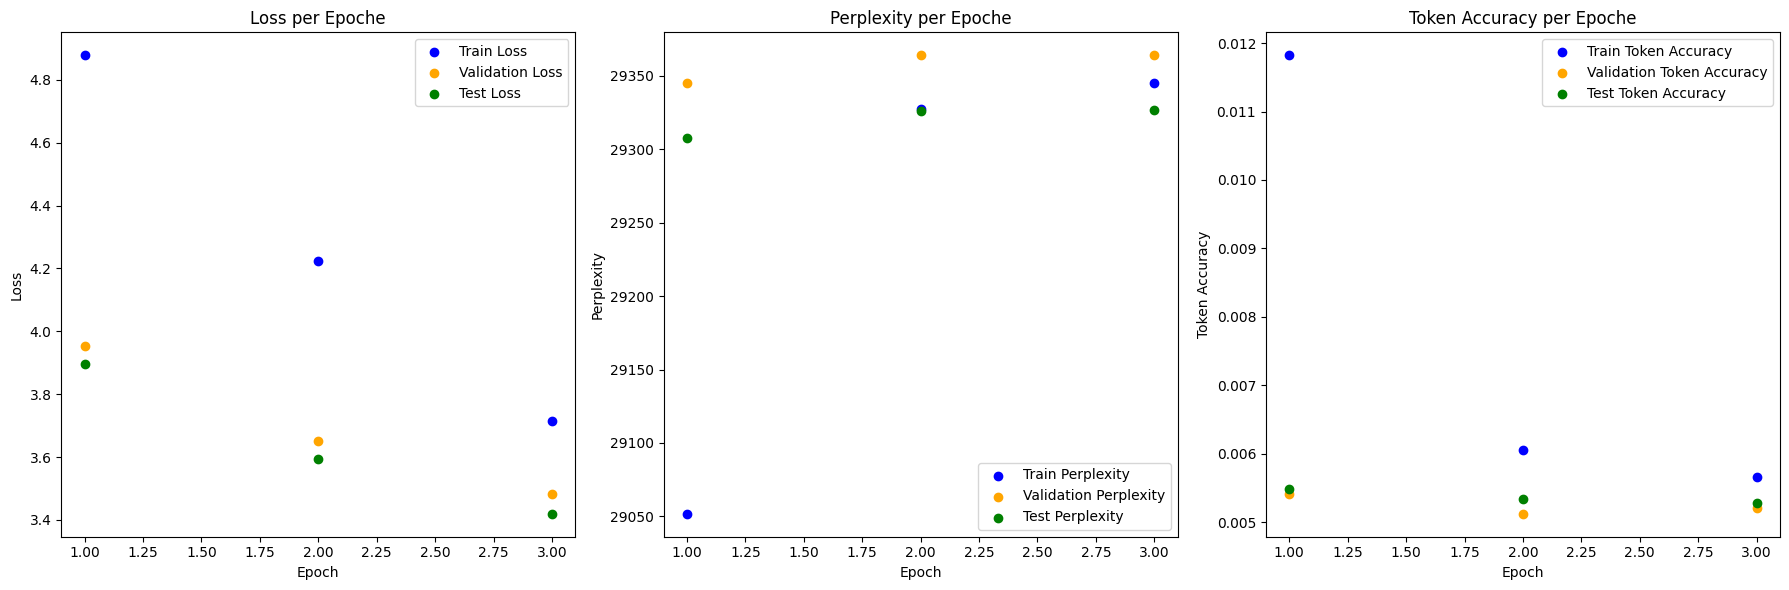

In [46]:
#3. Grafico a dispersione (Scatter Plot)
#Anche se meno comune per questo tipo di dati, un grafico a dispersione può mostrare i punti dati individuali e può essere utile per identificare outlier.
import matplotlib.pyplot as plt

# Creazione del grafico a dispersione
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Grafico per la perdita
axs[0].scatter(df_metrics['epoch'], df_metrics['train_loss'], color='blue', label='Train Loss')
axs[0].scatter(df_metrics['epoch'], df_metrics['val_loss'], color='orange', label='Validation Loss')
axs[0].scatter(df_metrics['epoch'], df_metrics['test_loss'], color='green', label='Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss per Epoche')
axs[0].legend()

# Grafico per la perplessità
axs[1].scatter(df_metrics['epoch'], df_metrics['train_perplexity'], color='blue', label='Train Perplexity')
axs[1].scatter(df_metrics['epoch'], df_metrics['val_perplexity'], color='orange', label='Validation Perplexity')
axs[1].scatter(df_metrics['epoch'], df_metrics['test_perplexity'], color='green', label='Test Perplexity')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Perplexity')
axs[1].set_title('Perplexity per Epoche')
axs[1].legend()

# Grafico per l'accuratezza dei token
axs[2].scatter(df_metrics['epoch'], df_metrics['train_token_accuracy'], color='blue', label='Train Token Accuracy')
axs[2].scatter(df_metrics['epoch'], df_metrics['val_token_accuracy'], color='orange', label='Validation Token Accuracy')
axs[2].scatter(df_metrics['epoch'], df_metrics['test_token_accuracy'], color='green', label='Test Token Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Token Accuracy')
axs[2].set_title('Token Accuracy per Epoche')
axs[2].legend()

plt.tight_layout()
plt.show()


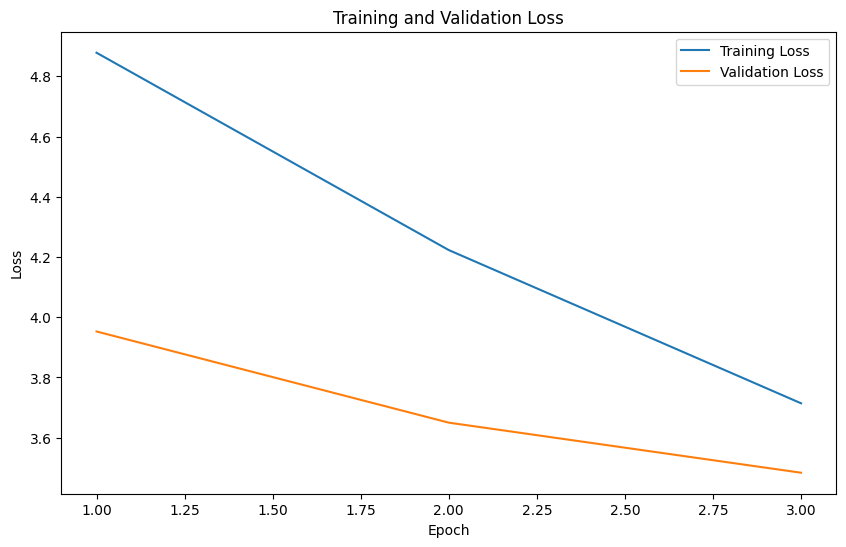

In [47]:
# Traccia i grafici per il training e validation loss
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['epoch'], df_metrics['train_loss'], label='Training Loss')
plt.plot(df_metrics['epoch'], df_metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

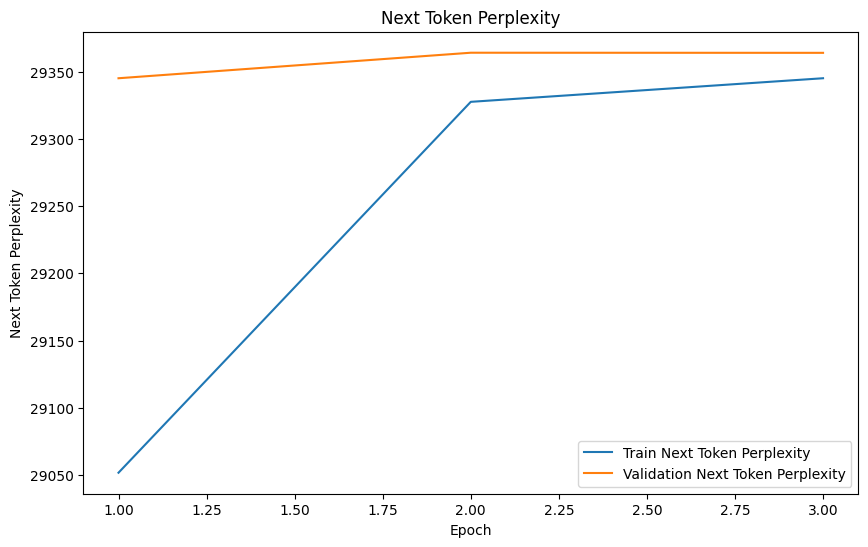

In [48]:
# Grafico per next_token_perplexity
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['epoch'], df_metrics['train_perplexity'], label='Train Next Token Perplexity')
plt.plot(df_metrics['epoch'], df_metrics['val_perplexity'], label='Validation Next Token Perplexity')
plt.xlabel('Epoch')
plt.ylabel('Next Token Perplexity')
plt.legend()
plt.title('Next Token Perplexity')
plt.show()


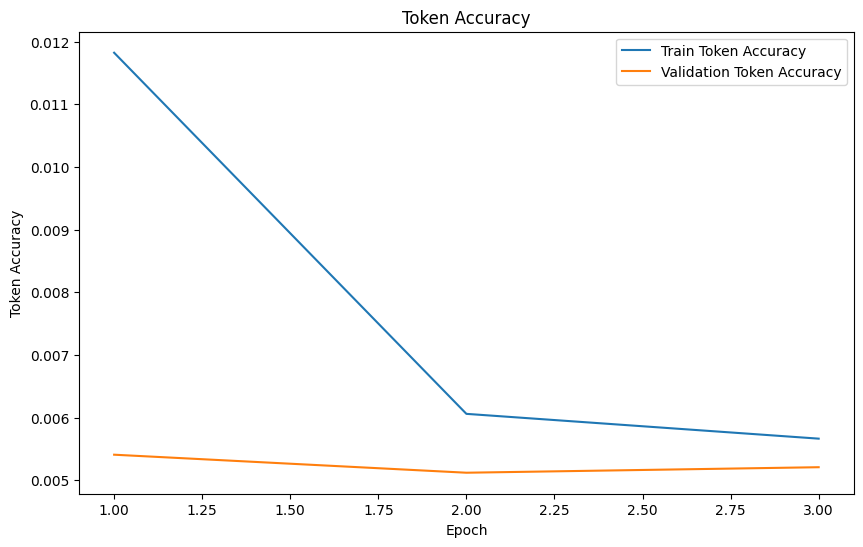

In [49]:
# Grafico per token_accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_metrics['epoch'], df_metrics['train_token_accuracy'], label='Train Token Accuracy')
plt.plot(df_metrics['epoch'], df_metrics['val_token_accuracy'], label='Validation Token Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Token Accuracy')
plt.legend()
plt.title('Token Accuracy')
plt.show()

#CONFIGURAZIONE YAML PER VALUTAZIONE GRAFICI:
yaml_config_template = """

model_type: llm

base_model: {model_path}


input_features:

  - name: DOMANDE

    type: text

    preprocessing:

      max_sequence_length: 300

      truncation: true     

      lowercase: true  

output_features:

  - name: RISPOSTE

    type: text

    preprocessing:

      max_sequence_length: 300

      truncation: true

    metrics:

      - type: bert_score

        model: dbmdz/bert-base-italian-uncased

      - type: rouge  # Aggiungi metriche ROUGE per valutare meglio le risposte generate

      - type: perplexity  # Aggiungi perplexity come metrica

prompt:

  template: >-

    Genera una risposta per la seguente domanda, come se fossi un esperto cardiologo.
    Le risposte devono essere empatiche, di senso compiuto e LE FRASI DEVONO TERMINARE CON UN PUNTO e essere lunghe massimo 60 token.
    ### Domanda: {DOMANDE}

    ### Risposta (Deve terminare con un punto e essere di senso compiuto):

generation:

  temperature: 0.6  # Abbassa la temperatura per risposte più coerenti

  max_new_tokens: 60

  top_p: 0.9  # Aggiungi top_p per migliorare la qualità delle risposte


adapter:

  type: lora


quantization:

  bits: 4


preprocessing:

  split:

    type: fixed


trainer:

  type: finetune

  epochs: 100  # Aumenta il numero di epoche per un fine-tuning più approfondito
  
  batch_size: 8  # Aumenta la dimensione del batch se la memoria lo permette
  
  eval_batch_size: 4
  
  gradient_accumulation_steps: 2  # Regola in base alla memoria disponibile
  
  learning_rate: 3.0e-5  # Prova con un learning rate più basso
  
  enable_gradient_checkpointing: true
  
  weight_decay: 0.01  # Aggiungi weight decay per regolarizzare
  
  dropout_rate: 0.1  # Aggiungi dropout per regolarizzare
  
  learning_rate_scheduler:
  
    decay: cosine
  
    warmup_fraction: 0.1  # Mantieni il warmup fraction
  
    reduce_on_plateau: 0
  
  checkpoint_interval: 500  # Salva un checkpoint ogni 500 steps


early_stopping:

  monitor: val_loss

  patience: 3

  mode: min


logging:

  log_to_tensorboard: true


callbacks:

  - type: progress_bar

  - type: model_checkpoint

    save_best_only: true

    monitor: val_loss

    mode: min

  - type: early_stopping

    monitor: val_loss

    patience: 3

    mode: min

  """

#COMMENTO DEI GRAFICI:
##TOKEN ACCURACY:
Mostra l'andamento dell'accuratezza dei token (Token Accuracy) durante le epoche di addestramento del tuo modello. L'asse X rappresenta il numero di epoche, mentre l'asse Y rappresenta l'accuratezza dei token.
* DECLINO PROGRESSIVO:
L'accuratezza dei token inizia a circa 0.06 (6%) e diminuisce progressivamente fino a circa 0.02 (2%) verso la fine del training.
Questo declino indica che il modello sta diventando meno accurato nel prevedere i token corretti man mano che l'addestramento procede.
>>> Possibile OVERFITTING O PROBLEMI DI ADDESTRAMENTO:
Un declino continuo e significativo nell'accuratezza dei token può indicare che il modello sta sovraccaricando il rumore presente nel set di dati di training, o potrebbe esserci un problema nella configurazione dell'addestramento.
Un'altra possibilità è che il modello stia incontrando difficoltà con il set di dati e non stia apprendendo in modo efficace.

**SOLUZIONI:**
1. Verifica del Set di Dati:
Assicurati che il set di dati di training sia di alta qualità e bilanciato. Dati rumorosi o squilibrati possono influire negativamente sull'addestramento del modello.

2. Regolazione dei Parametri di Addestramento:
Prova a regolare l'ipotesi di apprendimento (learning rate), la
dimensione del batch, e altre iperparametri per migliorare le prestazioni del modello.
Potresti voler aggiungere tecniche di regolarizzazione come il dropout per prevenire l'overfitting.

3. Early Stopping:
Implementa l'early stopping per interrompere l'addestramento se l'accuratezza dei token continua a diminuire, evitando così l'overfitting.

5. Analisi dei Modelli di Perdita:
Oltre all'accuratezza dei token, osserva anche l'andamento della perdita (loss). Un'analisi combinata delle metriche può fornire ulteriori indicazioni su come migliorare l'addestramento del modello.

##NEXT TOKEN PERPLEXITY
L'asse X rappresenta il numero di epoche, mentre l'asse Y rappresenta la perplexity del prossimo token. La perplexity misura quanto bene il modello prevede la sequenza di token. Valori più bassi di perplexity indicano una migliore capacità di previsione.

* DECLINO PROGRESSIVO: La perplexity inizia intorno a 28500 e diminuisce progressivamente fino a circa 26000 verso la fine del training. Questo declino indica che il modello sta migliorando nella previsione dei token successivi man mano che l'addestramento procede.
Il modello sta diventando più preciso nelle sue previsioni.

Confrontando questo grafico con quello dell'accuratezza dei token che hai fornito in precedenza, notiamo un contrasto interessante:
Accuratezza dei Token: Mostra un declino costante, suggerendo che il modello sta diventando meno preciso nel prevedere i token corretti.
Next Token Perplexity: Mostra un declino, suggerendo che il modello sta migliorando nella previsione delle sequenze.

##TRAINING LOSS
mostra l'andamento della perdita di addestramento (Training Loss) durante le epoche di addestramento del tuo modello. L'asse X rappresenta il numero di epoche, mentre l'asse Y rappresenta il valore della perdita.

* DECLINO PROGRESSIVO: La perdita inizia intorno a 7.5 e diminuisce progressivamente fino a circa 4.0 verso la fine del training. Questo declino indica che il modello sta migliorando nell'addestramento, riducendo l'errore nelle sue previsioni.
Indica che il modello sta imparando dai dati di training e sta migliorando nel tempo.

Considera l'aggiunta di tecniche di regolarizzazione come il dropout o la weight decay per prevenire l'overfitting e migliorare la generalizzazione del modello.

In [50]:
import shutil
from google.colab import files

# Comprimi la directory FineTuned_GPT2_Ludwig in un file zip
shutil.make_archive('FineTuned_GPT2_Ludwig', 'zip', 'FineTuned_GPT2_Ludwig')

# Scarica il file zip
files.download('FineTuned_GPT2_Ludwig.zip')

# Comprimi la directory del modello
#!zip -r FineTuned_GPT_Ludwig.zip FineTuned_GPT2_Ludwig

# Scarica il file compresso sul tuo PC
#files.download('FineTuned_GPT2_Ludwig.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [51]:
# Salva i risultati in un nuovo file CSV
results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Percorso del file da salvare
file_path = os.path.join(results_dir, 'bertscore_results1.csv')

df_pred.to_csv(file_path, index=False)

import shutil

# Percorso del file zip
zip_file = 'results.zip'

# Comprime la cartella 'results'
shutil.make_archive('results', 'zip', 'results')

print(f"Cartella compressa in: {zip_file}")

# Scarica il file zip
files.download(zip_file)

Cartella compressa in: results.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>